# Numpy operations test

Results from basic numpy operations benchmarks.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in kilobytes (KiB).

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Defined tests

Currently, there are 9 different variants of benchmarks
- Matrix Multiplication
- Singular Value Decomposition (SVD)
- Cholesky Decomposition
- Eigen Decomposition
- Matrix Inversion
- 2-Dimensional Real FFT
- 2-Dimensional Real Inverse FFT
- 2-Dimensional Complex FFT
- 2-Dimensional Complex Inverse FFT

Each variant run with different number of threads, which is the test parameterisation. Please refer to `reframe_numpy.py` for benchmark runtime configurations. 

## Latest run performance metrics

All the performance metrics are tabulated from the latest benchmark run for different systems/parititons and programming environments

### Small test case results
These results correspond to small image size of the benchmark. 

The table shows results for different systems/partition/environments, variant of benchmark, different number of cores and **small** sized benchmark

In [4]:
df = modules.utils.tabulate_last_perf(test='FftCpuTest*',
                                     root=PERFLOG_DIR,
                                     extras=['num_threads'])

# Sorts size ascending followed by real before complex
# This is necessary because all other locations, including the perflog, are sorted like this
df = df.reindex(
    sorted(
        sorted(df.index, key=lambda idx: ' '.join(idx.split(' ')[1:2]), reverse=True),
        key=lambda idx: int(idx.split('x')[0])
    )
)

df = df.transpose() # so now cols are all, single
df = df.sort_values(['case', 'num_threads'])
display(df)

perf_var                                                   32x32 real fft time  \
case                                          num_threads                        
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24                      0.002102   
generic:default:builtin                       12                      0.000030   
generic:default:gnu                           12                      0.000029   
generic:default:numpy                         12                      0.000023   
generic:python:numpy                          12                      0.000022   

perf_var                                                   32x32 real ifft time  \
case                                          num_threads                         
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24                       0.000034   
generic:default:builtin                       12                       0.000027   
generic:default:gnu                           12                       0.000027   
generic:default:numpy                         12                       0.000020   
generic:python:numpy                          12                       0.000020   

perf_var                                                   32x32 complex fft time  \
case                                          num_threads                           
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24                         0.000037   
generic:default:builtin                       12                         0.000027   
generic:default:gnu                           12                         0.000027   
generic:default:numpy                         12                         0.000020   
generic:python:numpy                          12                         0.000023   

perf_var                                                   32x32 complex ifft time  \
case                                          num_threads                            
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24                          0.000036   
generic:default:builtin                       12                          0.000027   
generic:default:gnu                           12                          0.000028   
generic:default:numpy                         12                          0.000020   
generic:python:numpy                          12                          0.000019   

perf_var                                                   128x128 real fft time  \
case                                          num_threads                          
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24                        0.000295   
generic:default:builtin                       12                        0.000294   
generic:default:gnu                           12                        0.000294   
generic:default:numpy                         12                        0.000268   
generic:python:numpy                          12                        0.000260   

perf_var                                                   128x128 real ifft time  \
case                                          num_threads                           
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24                         0.000290   
generic:default:builtin                       12                         0.000215   
generic:default:gnu                           12                         0.000218   
generic:default:numpy                         12                         0.000175   
generic:python:numpy                          12                         0.000172   

perf_var                                                   128x128 complex fft time  \
case                                          num_threads                             
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24                           0.000281   
generic:default:builtin                       12                           0.000201   
generic:default:gnu                           12                           0.000204   
generic:default:numpy   

## Performance History

The plot shows the Degrid rate, write and read bandwidths for each system/partition/environment combination. The performance logs include a git reference (as a tag "git=<ref>") to refer the state of repository when the test was performed.

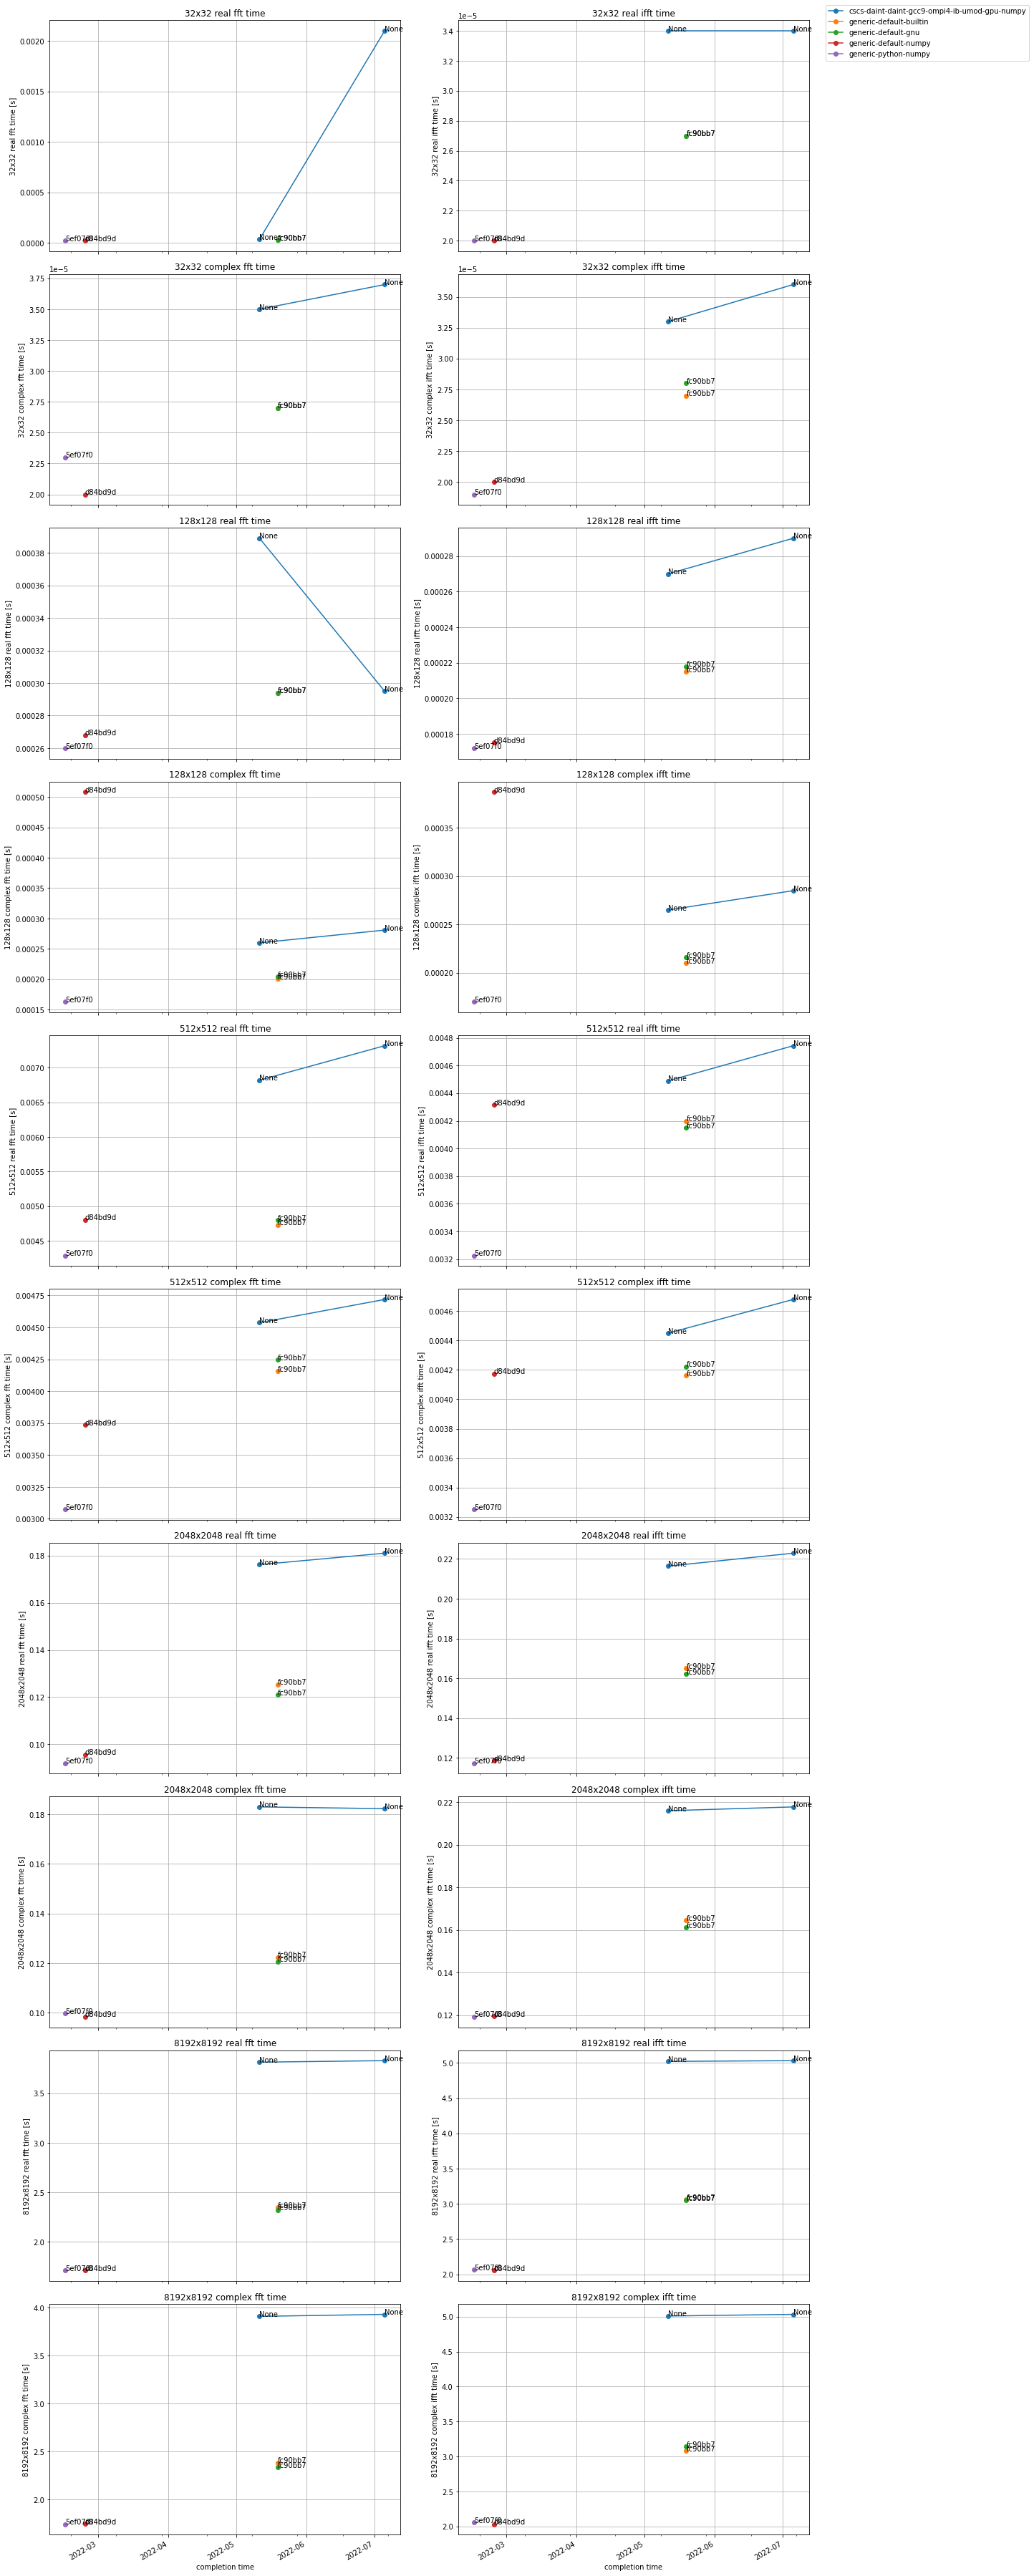

In [5]:
test='FftCpuTest'
ncols = 2

perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=['num_threads'], test=test)
perf_vars = perf_records["perf_var"].unique()

if perf_records is None:
    print('%s: no performance logs found' % test)

nrows = (len(perf_vars)+1)//ncols
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,5*nrows), sharex='all')
axs = axs.flatten()
for ax, perf_var in zip(axs, perf_vars):
    for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
        # filter to only Gflops records (might have others)
        data = data.loc[data['perf_var'] == perf_var]
        data.plot(ax=ax, x='completion_time', y='perf_value', style=['o-'], label='-'.join(spe), legend=None)

        # annotate points with git_ref:
        for x, y, ref in zip(data['completion_time'], data['perf_value'], data['git']):
            if not pd.isnull(ref):
                ax.annotate(ref[:7], (x, y))
    ax.set_xlabel('completion time')
    ax.set_ylabel(f'{perf_var} [s]')
    ax.set_title(f"{perf_var}")
    ax.grid()
handles, labels = axs[0].get_legend_handles_labels()
fig.tight_layout()
fig.legend(handles, labels, bbox_to_anchor=(1.00, 1), loc='upper left');